In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Parameter windowing
input_width = 60*4
label_width = 60
shift = label_width
total_window_size = input_width + shift
OUT_STEPS = label_width
# Definisikan irisan untuk input dan label
input_slice = slice(0, input_width)
label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
train_df = None
output_selected=['RRU.PrbUsedDl']
train_name_cells=['S1/B2/C1']
test_name_cells=['S7/B2/C1']

In [2]:
pd.read_csv('D:\\KULIAH\\teep\\AI\\dataset\\08_01_2024\\CellReports.csv')['Viavi.Cell.Name'].unique()

array(['S1/B2/C1', 'S7/B2/C1', 'S8/B2/C1', 'S9/B2/C1', 'S1/B13/C1',
       'S1/B13/C2', 'S1/B13/C3', 'S2/B13/C1', 'S2/B13/C2', 'S2/B13/C3',
       'S3/B13/C1', 'S3/B13/C2', 'S3/B13/C3', 'S4/B13/C1', 'S4/B13/C2',
       'S4/B13/C3', 'S5/B13/C1', 'S5/B13/C2', 'S5/B13/C3', 'S6/B13/C1',
       'S6/B13/C2', 'S6/B13/C3', 'S7/B13/C1', 'S7/B13/C2', 'S7/B13/C3',
       'S8/B13/C1', 'S8/B13/C2', 'S8/B13/C3', 'S9/B13/C1', 'S9/B13/C2',
       'S9/B13/C3', 'S10/B13/C1', 'S10/B13/C2', 'S10/B13/C3',
       'S11/B13/C1', 'S11/B13/C2', 'S11/B13/C3', 'S12/B13/C1',
       'S12/B13/C2', 'S12/B13/C3', 'S13/B13/C1', 'S13/B13/C2',
       'S13/B13/C3', 'S1/N77/C1', 'S1/N77/C2', 'S1/N77/C3', 'S3/N77/C1',
       'S3/N77/C2', 'S3/N77/C3', 'S4/N77/C1', 'S4/N77/C2', 'S4/N77/C3'],
      dtype=object)

In [3]:
def  import_data(file_path="D:\\KULIAH\\teep\\AI\\dataset\\08_01_2024\\CellReports.csv"):
    
    df_1=pd.read_csv(file_path)
    convert_time=pd.to_datetime(df_1['timestamp'], unit='ms',origin='unix')
    df_1.insert(df_1.columns.get_loc('timestamp') + 1, 'datetime_column', convert_time)
    df_1.insert(df_1.columns.get_loc('datetime_column') + 2, 'hour', df_1['datetime_column'].dt.hour+df_1['datetime_column'].dt.minute/60)
    df_1.set_index('datetime_column', inplace=True)
    df_1.drop(columns=['timestamp'], inplace=True)
    df_1['sin_time'] = np.sin(df_1['hour'] * (2 * np.pi / 24))
    df_1['cos_time'] = np.cos(df_1['hour']* (2 * np.pi / 24))
    seleted_columns = ['Viavi.Cell.Name','RRU.PrbUsedDl', 'sin_time', 'cos_time'] 
    df_2= df_1[seleted_columns].copy()
    cell_name= train_name_cells+ test_name_cells
    df= df_2[df_2['Viavi.Cell.Name'].isin(cell_name)].copy()
    
    return df, cell_name

In [4]:
def standardize_data(data, train_df, isoutput=True, column_output=output_selected):
    if isoutput:
        median = train_df[column_output].median().values
        q1 = train_df[column_output].quantile(0.25).values
        q3 = train_df[column_output].quantile(0.75).values
    else:
        median = train_df.median().values
        q1 = train_df.quantile(0.25).values
        q3 = train_df.quantile(0.75).values

    iqr = q3 - q1

    # Reshape for broadcasting with 2D matrix
    median = median.reshape(1, -1)
    iqr = iqr.reshape(1, -1)

    return (data - median) / iqr

def inverse_standardize_data(data, train_df, isoutput=True, column_output=output_selected):
    if isoutput:
        median = train_df[column_output].median().values
        q1 = train_df[column_output].quantile(0.25).values
        q3 = train_df[column_output].quantile(0.75).values
    else:
        median = train_df.median().values
        q1 = train_df.quantile(0.25).values
        q3 = train_df.quantile(0.75).values

    iqr = q3 - q1

    # Reshape for broadcasting with 2D matrix
    median = median.reshape(1, -1)
    iqr = iqr.reshape(1, -1)

    return data * iqr + median

In [5]:
def make_windows(data_x,data_y, total_window_size, input_slice, labels_slice):
    x = []
    y = []
    for i in range(len(data_x) - total_window_size + 1):
        window_x = data_x[i:i+total_window_size]
        x.append(window_x[input_slice])

    for i in range(len(data_y) - total_window_size + 1):
        window_y= data_y[i:i+total_window_size]
        y.append(window_y[labels_slice])

    return np.array(x), np.array(y)


In [6]:
def compute_metrics(actual_df, predictions_df):
    mae = mean_absolute_error(actual_df, predictions_df)
    mse = mean_squared_error(actual_df, predictions_df)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_df - predictions_df) / actual_df)) * 100
    return mae, mape, mse, rmse

def process_predictions(model, x_scaled, actual_df, input_width, label_width, columns):
    predictions = model.predict(x_scaled[slice(None, None, label_width), :, :])
    predictions_reshaped = predictions.reshape(-1, len(columns))
    predictions_unscaled = inverse_standardize_data(predictions_reshaped, isoutput=True, train_df=train_df)
    predictions_df = pd.DataFrame(predictions_unscaled, columns=columns, index=actual_df[input_width:].index)
    return predictions_df
def compute_error( x_scaled, actual_df, columns, model):
    
    # Process predictions for training and validation sets
    predictions_df = process_predictions(model, x_scaled, actual_df, input_width, label_width, columns)

    df_predact= pd.concat((predictions_df.rename(columns={columns[0]: '%spredict'%columns[0]}), actual_df[input_width:]), axis=1)
    
    display(df_predact)
    mae, mape, mse, rmse = compute_metrics(actual_df[input_width:], predictions_df)
    
    print(f"MAE: {mae}, MAPE %: {mape}, MSE: {mse}, RMSE: {rmse}")
    return df_predact

In [7]:

def plot_predictions(val_df, x_val_scaled, model, val_scaled, input_width, label_width, num_features):
    num_output = 1


    # Predictions for validation data
    val_predictions = model.predict(x_val_scaled[slice(None,None,label_width), :, :])
    predictions_reshaped = val_predictions.reshape(-1, num_output)
    predictions_unscaled = inverse_standardize_data(predictions_reshaped, isoutput=True, train_df=train_df)
    val_predictions_df = pd.DataFrame(predictions_unscaled, columns=output_selected, index=val_df.index)

    # Generate new predictions
    val_new = val_scaled.tail(input_width).to_numpy()
    val_new = val_new.reshape(1, -1, num_features)
    generate_predictions = model.predict(val_new)
    generate_predictions = inverse_standardize_data(generate_predictions.reshape(-1, num_output), isoutput=True, train_df=train_df)
    generate_predictions_df = pd.DataFrame(generate_predictions, columns=output_selected, index=val_df.tail(label_width).index + pd.DateOffset(hours=1))

    # Combine predictions
    all_predictions = pd.concat([val_predictions_df, generate_predictions_df], axis=0)
    inputs_graph = val_df[output_selected].iloc[-label_width * 3:-label_width]
    labels_graph = val_df[output_selected].iloc[-label_width:]
    predictions_graph = all_predictions.loc[labels_graph.index]
    new_predictions_graph = all_predictions.loc[generate_predictions_df.index]

    # Plotting
    plt.figure(figsize=(16, 8))
    for n, feature in enumerate(all_predictions.columns):
        plt.subplot(len(all_predictions.columns), 1, n + 1)
        plt.plot(inputs_graph.index, inputs_graph[feature], label='Inputs for orange', marker='.', zorder=-100, markersize=5)
        plt.plot(labels_graph.index, labels_graph[feature], label='actual output for orange and inputs for red', marker='.', zorder=-100, c='#2ca02c')
        plt.scatter(predictions_graph.index, predictions_graph[feature], marker='X', edgecolors='k', label='Prediction', c='#ff7f0e', s=int(32 * 1.5))
        plt.scatter(new_predictions_graph.index, new_predictions_graph[feature], marker='+', label='New prediction', c='#FF012D', s=int(32 * 1.5))
        plt.ylabel(feature)
        plt.legend()

    plt.subplots_adjust(hspace=0.2, top=1)
    plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time
import tensorflow_addons as tfa

# Define the PinballLoss function
pinball_loss = tfa.losses.PinballLoss(tau=0.5, reduction=tf.keras.losses.Reduction.AUTO, name='pinball_loss')

d:\GAME\Anaconda\envs\tf_gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\GAME\Anaconda\envs\tf_gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [9]:


def running_program(train_df,val_df, index_cell, name_file, name_file_before):
    
    train_scaled = standardize_data(train_df, isoutput=False, train_df=train_df)
    val_scaled= standardize_data(val_df, isoutput=False, train_df=train_df)
    # Membuat windowed dataset untuk set pelatihan, validasi, dan pengujian

    x_train_scaled, y_train_scaled = make_windows(train_scaled.to_numpy(), train_scaled[output_selected].to_numpy(),total_window_size, input_slice, labels_slice)
    x_val_scaled, y_val_scaled = make_windows(val_scaled.to_numpy(), val_scaled[output_selected].to_numpy(),total_window_size, input_slice, labels_slice)
    print(x_train_scaled.shape, y_train_scaled.shape)
    num_features = x_train_scaled.shape[2]
    #name_file='2hour_cekpoint_1.hdf5'
    name_file='TCSM_CNN22.hdf5'
    model = tf.keras.models.load_model(name_file)
    columns = output_selected
    output_actual_train = train_df[columns]
    output_actual_val = val_df[columns]
    print("Training Metrics:")
    df_predact =compute_error(x_train_scaled,  output_actual_train,columns, model)
   # df_predact.to_csv('S1B2C1_predact.csv')
    print("\nValidation Metrics:")
    test_predact =compute_error(x_val_scaled,  output_actual_val,columns, model)
    test_predact.to_csv('S4N77C1.csv')
    print("Training Plot:")
    plot_predictions( output_actual_train[input_width:], x_train_scaled, model, train_scaled, input_width, label_width, num_features)
    print("\nValidation (test) Plot:")
    plot_predictions( output_actual_val[input_width:], x_val_scaled, model, val_scaled, input_width, label_width, num_features)
    


0
name_file:  4hour_cnn0802_dua_1.hdf5
name_file_before:  4hour_cnn0802_dua_0.hdf5
Cell Name:  S1/B2/C1
(11221, 240, 3) (11221, 60, 1)
Training Metrics:
6/6 [==============================] - 3s 13ms/step


,RRU.PrbUsedDlpredict,RRU.PrbUsedDl
datetime_column,,
2024-08-01 04:00:00,32.105313,14.966667
2024-08-01 04:01:00,29.415339,53.983333
2024-08-01 04:02:00,27.142293,17.550000
2024-08-01 04:03:00,38.926102,17.533333
2024-08-01 04:04:00,30.587900,47.766667
...,...,...
2024-08-08 23:55:00,32.055362,25.116667
2024-08-08 23:56:00,30.343586,24.666667
2024-08-08 23:57:00,27.619506,59.133333


MAE: 13.81246578956296, MAPE %: inf, MSE: 306.98844678028763, RMSE: 17.52108577629502

Validation Metrics:
6/6 [==============================] - 0s 8ms/step


,RRU.PrbUsedDlpredict,RRU.PrbUsedDl
datetime_column,,
2024-08-01 04:00:00,22.427259,1.766667
2024-08-01 04:01:00,3.963902,8.266667
2024-08-01 04:02:00,29.529122,6.433333
2024-08-01 04:03:00,20.122137,14.766667
2024-08-01 04:04:00,27.010888,4.016667
...,...,...
2024-08-08 23:55:00,45.805812,59.733333
2024-08-08 23:56:00,41.328257,37.333333
2024-08-08 23:57:00,45.675531,12.033333


MAE: 20.560933514820174, MAPE %: inf, MSE: 631.3917357249736, RMSE: 25.12750954083937
Training Plot:
1/1 [==============================] - 0s 39ms/step


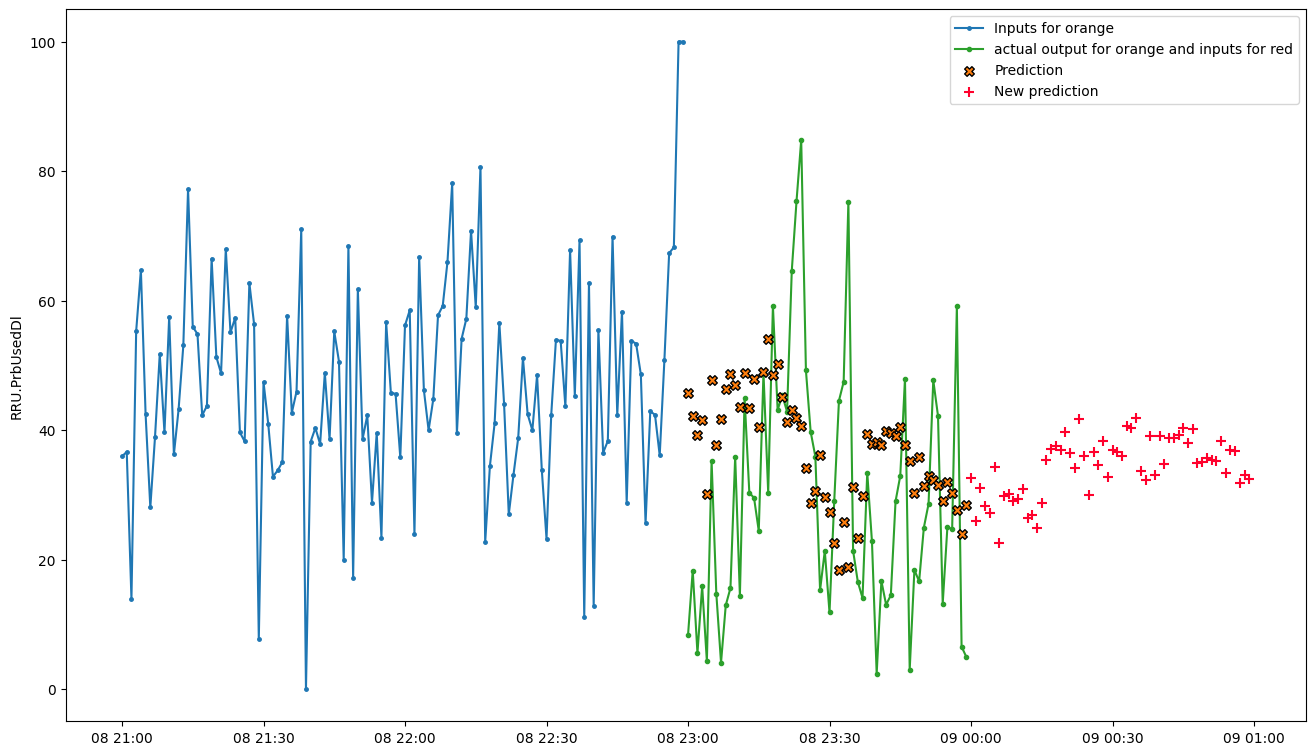


Validation (test) Plot:
1/1 [==============================] - 0s 18ms/step


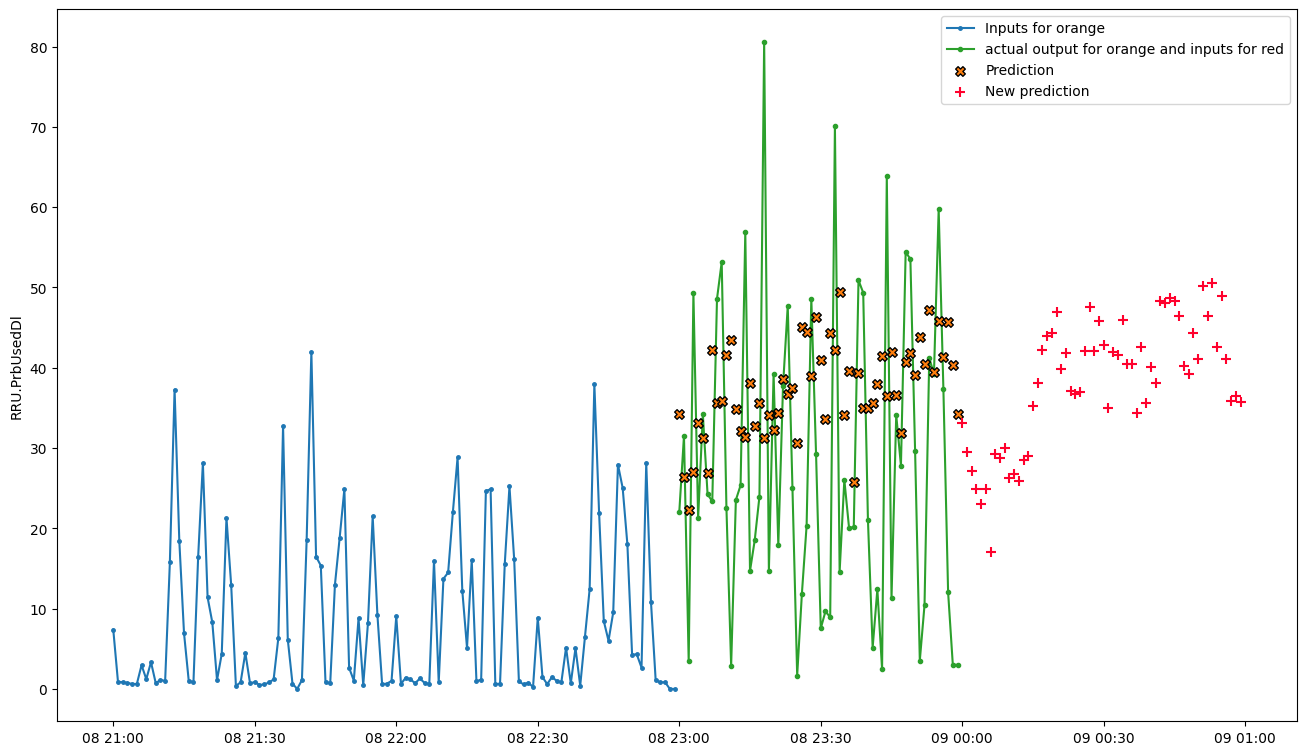

In [10]:
df_start, cell_name= import_data("D:\\KULIAH\\teep\\AI\\dataset\\08_01_2024\\CellReports.csv")
#now = datetime.datetime.now()
timestamp = "cnn0802_dua"
for index in range(0,1):
    print(index)

    train_df = df_start[df_start['Viavi.Cell.Name'] == train_name_cells[index]]
    train_df = train_df.loc[~train_df.index.duplicated()]
    train_df=train_df.drop(columns=['Viavi.Cell.Name']).astype(float).copy()

    val_df= df_start[df_start['Viavi.Cell.Name'] == test_name_cells[0]]
    val_df=val_df.loc[~val_df.index.duplicated()]
    val_df=val_df.drop(columns=['Viavi.Cell.Name']).astype(float).copy()

    name_file='4hour_%s_%s.hdf5'%(timestamp, index+1)
    name_file_before='4hour_%s_%s.hdf5'%(timestamp, index)
    print("name_file: ", name_file)
    print("name_file_before: ", name_file_before)
    print("Cell Name: ", cell_name[index])
    #display(train_df)
    running_program(train_df=train_df, val_df=val_df, index_cell=index, name_file=name_file, name_file_before=name_file_before)